In this work I classify images of sign language letters with convolutional network using PyTorch. 

First, let's import everything we need for work: 

In [1]:
import os
import random
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

%matplotlib inline

In [2]:
pytorch_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(pytorch_device)

cuda:0


In [3]:
data_raw = pd.read_csv('./sign_mnist_train.csv', sep=",")
test_data_raw = pd.read_csv('./sign_mnist_test.csv', sep=",")

labels = data_raw['label']
data_raw.drop('label', axis=1, inplace=True)
labels_test = test_data_raw['label']
test_data_raw.drop('label', axis=1, inplace=True)

data = data_raw.values
labels = labels.values
test_data = test_data_raw.values
labels_test = labels_test.values

data_raw.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,107,118,127,134,139,143,146,150,153,156,...,207,207,207,207,206,206,206,204,203,202
1,155,157,156,156,156,157,156,158,158,157,...,69,149,128,87,94,163,175,103,135,149
2,187,188,188,187,187,186,187,188,187,186,...,202,201,200,199,198,199,198,195,194,195
3,211,211,212,212,211,210,211,210,210,211,...,235,234,233,231,230,226,225,222,229,163
4,164,167,170,172,176,179,180,184,185,186,...,92,105,105,108,133,163,157,163,164,179


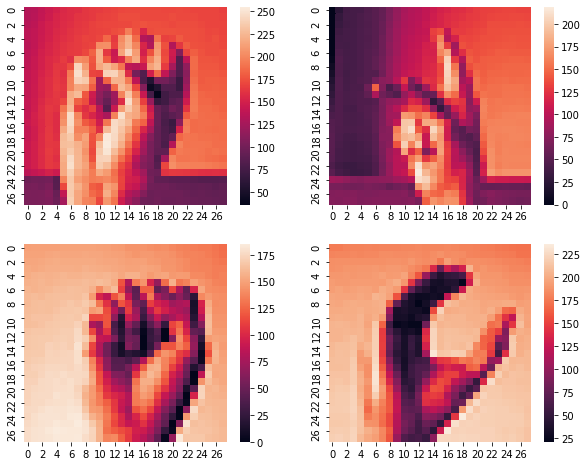

In [4]:
plt.figure(figsize=(10, 8))

pixels = data[10].reshape(28, 28)
plt.subplot(221)
sns.heatmap(data=pixels)

pixels = data[11].reshape(28, 28)
plt.subplot(222)
sns.heatmap(data=pixels)

pixels = data[20].reshape(28, 28)
plt.subplot(223)
sns.heatmap(data=pixels)

pixels = data[32].reshape(28, 28)
plt.subplot(224)
sns.heatmap(data=pixels)

In [5]:
import string

alph = {0:'a', 1:'b', 2:'c', 3:'d', 4:'e', 5:"f", 6:'g', 7:'h', 8:'i', 9:'j', 10:'k', 11:'l', 12:'m', 13:'n',
        14:'o', 15:'p', 16:'q', 17:'r', 18:'s', 19:'t', 20:'u', 21:'v', 22:'w', 23:'x', 24:'y', 25:'z'}

In [6]:
def reshape_to_2d(data, dim):
    reshaped = []
    for i in data:
        reshaped.append(i.reshape(1, dim, dim))

    return np.array(reshaped)

In [7]:
data = reshape_to_2d(data, 28)

x = torch.FloatTensor(data)
y = torch.LongTensor(labels.tolist())

test_labels = torch.LongTensor(labels_test.tolist())

test_data_formated = reshape_to_2d(test_data, 28)
test_data_formated = torch.FloatTensor(test_data_formated)

In [8]:
epochs = 50
batch_size = 200
learning_rate = 0.003
momentum = 0.7
num_classes = 26

In [9]:
class Network(nn.Module): 
    
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.pool1 = nn.MaxPool2d(2)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.pool2 = nn.MaxPool2d(2)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.pool3 = nn.MaxPool2d(2)
        
        self.fc1 = nn.Linear(128 * 3 * 3, 128) 
        self.fc2 = nn.Linear(128, 26)    
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = F.relu(x)
                
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x
    
    def test(self, predictions, labels):
        
        self.eval()
        correct = 0
        for p, l in zip(predictions, labels):
            if p == l:
                correct += 1
        
        acc = correct / len(predictions)
        print("Correct predictions: %5d / %5d (%5f)" % (correct, len(predictions), acc))
        
    
    def evaluate(self, predictions, labels):
                
        correct = 0
        for p, l in zip(predictions, labels):
            if p == l:
                correct += 1
        
        acc = correct / len(predictions)
        return(acc)

In [10]:
net = Network().to(pytorch_device)
print(net)

Network(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1152, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=26, bias=True)
)


In [11]:
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)
criterion = nn.CrossEntropyLoss()

In [12]:
loss_log = []
acc_log = []

for e in range(epochs):
    for i in range(0, x.shape[0], batch_size):
        x_mini = x[i:i + batch_size].to(pytorch_device)
        y_mini = y[i:i + batch_size].to(pytorch_device)
        
        optimizer.zero_grad()
        net_out = net(Variable(x_mini))
        
        loss = criterion(net_out, Variable(y_mini))
        loss.backward()
        optimizer.step()
        
        if i % 1000 == 0:
            #pred = net(Variable(test_data_formated))
            loss_log.append(loss.item())
            acc_log.append(net.evaluate(torch.max(net(Variable(test_data_formated[:500].to(pytorch_device))).data, 1)[1], 
                                        test_labels[:500].to(pytorch_device)))
        
    print('Epoch: {} - Loss: {:.6f}'.format(e + 1, loss.item()))

Epoch: 1 - Loss: 0.582316
Epoch: 2 - Loss: 0.136678
Epoch: 3 - Loss: 0.025144
Epoch: 4 - Loss: 0.011831
Epoch: 5 - Loss: 0.007208
Epoch: 6 - Loss: 0.004991
Epoch: 7 - Loss: 0.003506
Epoch: 8 - Loss: 0.002604
Epoch: 9 - Loss: 0.002104
Epoch: 10 - Loss: 0.001753
Epoch: 11 - Loss: 0.001494
Epoch: 12 - Loss: 0.001294
Epoch: 13 - Loss: 0.001142
Epoch: 14 - Loss: 0.001027
Epoch: 15 - Loss: 0.000927
Epoch: 16 - Loss: 0.000845
Epoch: 17 - Loss: 0.000775
Epoch: 18 - Loss: 0.000717
Epoch: 19 - Loss: 0.000663
Epoch: 20 - Loss: 0.000617
Epoch: 21 - Loss: 0.000575
Epoch: 22 - Loss: 0.000538
Epoch: 23 - Loss: 0.000506
Epoch: 24 - Loss: 0.000476
Epoch: 25 - Loss: 0.000449
Epoch: 26 - Loss: 0.000426
Epoch: 27 - Loss: 0.000404
Epoch: 28 - Loss: 0.000382
Epoch: 29 - Loss: 0.000365
Epoch: 30 - Loss: 0.000348
Epoch: 31 - Loss: 0.000332
Epoch: 32 - Loss: 0.000317
Epoch: 33 - Loss: 0.000304
Epoch: 34 - Loss: 0.000291
Epoch: 35 - Loss: 0.000280
Epoch: 36 - Loss: 0.000269
Epoch: 37 - Loss: 0.000258
Epoch: 38 

Blue line represents the loss function, and the orange one represents the accuracy.

No handles with labels found to put in legend.


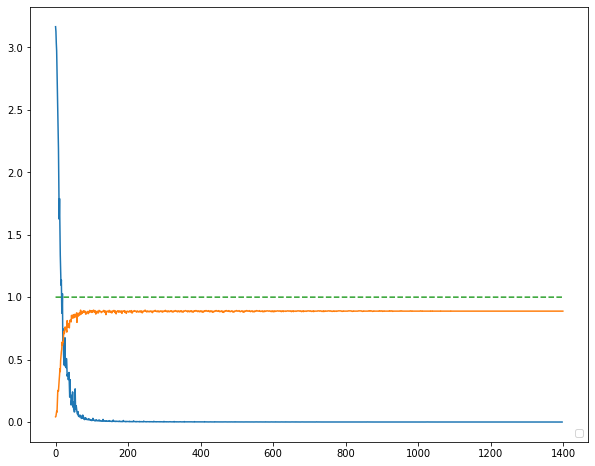

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,8))
plt.plot(loss_log[2:])
plt.plot(acc_log)
plt.plot(np.ones(len(acc_log)), linestyle='dashed')
plt.legend(loc='lower right', fontsize=10)

Prediction: h
Actual Label: h
Prediction: i
Actual Label: i
Prediction: i
Actual Label: i
Prediction: v
Actual Label: v


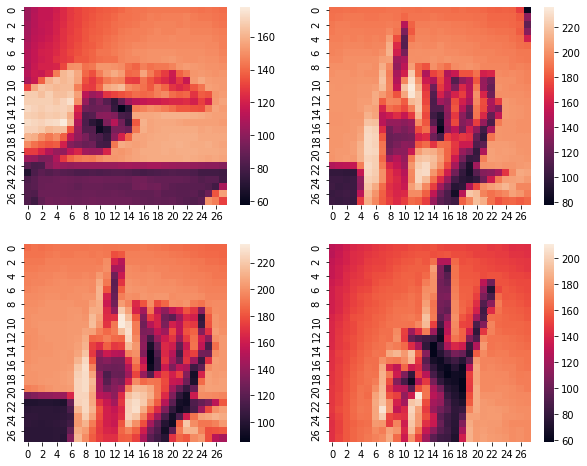

In [14]:
plt.figure(figsize=(10, 8))

sample = 30
pixels = test_data[sample].reshape(28, 28)
plt.subplot(221)
sns.heatmap(data=pixels)
lab = labels_test[sample]
test_sample = torch.FloatTensor([test_data[sample].reshape(1, 28, 28).tolist()]).to(pytorch_device)
test_var_sample = Variable(test_sample)
net_out_sample = net(test_var_sample)

print("Prediction: {}".format(alph[torch.max(net_out_sample.data, 1)[1].cpu().numpy()[0]]))
print("Actual Label: {}".format(alph[lab]))

sample = 42
pixels = test_data[sample].reshape(28, 28)
plt.subplot(222)
sns.heatmap(data=pixels)
lab = labels_test[sample]
test_sample = torch.FloatTensor([test_data[sample].reshape(1, 28, 28).tolist()]).to(pytorch_device)
test_var_sample = Variable(test_sample)
net_out_sample = net(test_var_sample)

print("Prediction: {}".format(alph[torch.max(net_out_sample.data, 1)[1].cpu().numpy()[0]]))
print("Actual Label: {}".format(alph[lab]))

sample = 100
pixels = test_data[sample].reshape(28, 28)
plt.subplot(223)
sns.heatmap(data=pixels)
lab = labels_test[sample]
test_sample = torch.FloatTensor([test_data[sample].reshape(1, 28, 28).tolist()]).to(pytorch_device)
test_var_sample = Variable(test_sample)
net_out_sample = net(test_var_sample)

print("Prediction: {}".format(alph[torch.max(net_out_sample.data, 1)[1].cpu().numpy()[0]]))
print("Actual Label: {}".format(alph[lab]))

sample = 22
pixels = test_data[sample].reshape(28, 28)
plt.subplot(224)
sns.heatmap(data=pixels)
lab = labels_test[sample]
test_sample = torch.FloatTensor([test_data[sample].reshape(1, 28, 28).tolist()]).to(pytorch_device)
test_var_sample = Variable(test_sample)
net_out_sample = net(test_var_sample)

print("Prediction: {}".format(alph[torch.max(net_out_sample.data, 1)[1].cpu().numpy()[0]]))
print("Actual Label: {}".format(alph[lab]))

In [15]:
torch.cuda.empty_cache()

predictions = net(Variable(test_data_formated.to(pytorch_device)))
net.test(torch.max(predictions.data, 1)[1], test_labels)

Correct predictions:  6458 /  7172 (0.900446)
